In [1]:
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [2]:
ARTIFACT_DIR = "artifact/"
csv_file = 'data/full_emoji.csv'
data = pd.read_csv(csv_file)
data.sample(n=5)

,#,emoji,unicode,name,Apple,Google,Facebook,Windows,Twitter,JoyPixels,Samsung,Gmail,SoftBank,DoCoMo,KDDI
998,999,✨,U+2728,sparkles,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPAKIFAJh3AF5L...","data:image/png;base64,R0lGODlhDwAPAJEAAP///wAA...","data:image/png;base64,R0lGODlhDAAMAIABAP+ZAP//...","data:image/png;base64,R0lGODlhDgAPAKIGAP+Z//+Z..."
1184,1185,📔,U+1F4D4,notebook with decorative cover,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDgAPALMPABofHe7u...",NaN,NaN,"data:image/png;base64,R0lGODlhDgAPAKIGADNm/5nM..."
530,531,🦄,U+1F984,unicorn,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,NaN,NaN,NaN
1457,1458,❇,U+2747,sparkle,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPALMPAP8RAP9G...",NaN,NaN,"data:image/png;base64,R0lGODlhDgAPAKIFAP//AP/M..."
860,861,🚒,U+1F692,fire engine,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwANALMPAM7FnjLK...","data:image/png;base64,R0lGODlhDwAPAHcAMSH+GlNv...",NaN,"data:image/png;base64,R0lGODlhDgAPALMOAP////9m..."


In [3]:
def save_plot(filename: str) -> None:
    out_path = os.path.join(ARTIFACT_DIR, os.path.basename(filename))
    plt.savefig(out_path, dpi=300, bbox_inches='tight')

def plot_weight_distributions(model, title):
    weight_params = [param for name, param in model.named_parameters() if 'weight' in name]
    num_weights = len(weight_params)
    num_cols = 4
    num_rows = math.ceil(num_weights / num_cols)

    plt.figure(figsize=(15, num_rows * 5))

    for i, param in enumerate(weight_params):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.hist(param.cpu().data.numpy().flatten(), bins=50)
        plt.title(f'Layer {i + 1} weights')

    plt.suptitle(title)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    save_plot(f"{title}.png")

def plot_loss_vs_epoch(lossG_list, lossD_real_list, lossD_fake_list, total_loss_list):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss vs Epoch")
    plt.plot(lossG_list, label="G")
    plt.plot(lossD_real_list, label="D Real")
    plt.plot(lossD_fake_list, label="D Fake")
    plt.plot(total_loss_list, label="Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    save_plot("losses_vs_epoch.png")

def get_label_for_row(df: pd.DataFrame, idx:int) -> int:
    return 1 if 'face' in df.loc[idx, "name"].lower() else 0

print(get_label_for_row(data, 12))
print(get_label_for_row(data, 1208))

1
0


In [4]:
class EmojiDataset(Dataset):
    def __init__(self, img_dirs, csv_file, transform=None):
        self.img_dirs = img_dirs
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, f'{img_id}.png')
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f'Image with ID {img_id} not found in any of the specified directories.')

        label = get_label_for_row(self.data, idx)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

img_dirs = [
    'data/image/Apple',
    'data/image/DoCoMo',
    'data/image/Facebook',
    'data/image/Gmail',
    'data/image/Google',
    'data/image/JoyPixels',
    'data/image/KDDI',
    'data/image/Samsung',
    'data/image/SoftBank',
    'data/image/Twitter',
    'data/image/Windows'
]
csv_file = 'data/full_emoji.csv'
dataset = EmojiDataset(img_dirs, csv_file, transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),  # Output: (1024, 4, 4)
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),  # Output: (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # Output: (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # Output: (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),     # Output: (3, 64, 64)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(1024 * 2 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.main(input)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [7]:
nz = 128  # Size of z latent vector (i.e. size of generator input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # Generate off the same noise each time for viz.

netG = Generator(nz).to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()

cuda


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weight initialization to the generator and discriminator
netG.apply(weights_init)
netD.apply(weights_init)

# Hyperparameters
lrD = 0.00005
lrG = 0.0001
clip_value = 0.9  # Let's try clipping w/ normal dist.

# Define optimizers
optimizerD = optim.AdamW(netD.parameters(), lr=lrD, betas=(0.8, 0.999))
optimizerG = optim.AdamW(netG.parameters(), lr=lrG, betas=(0.8, 0.999))

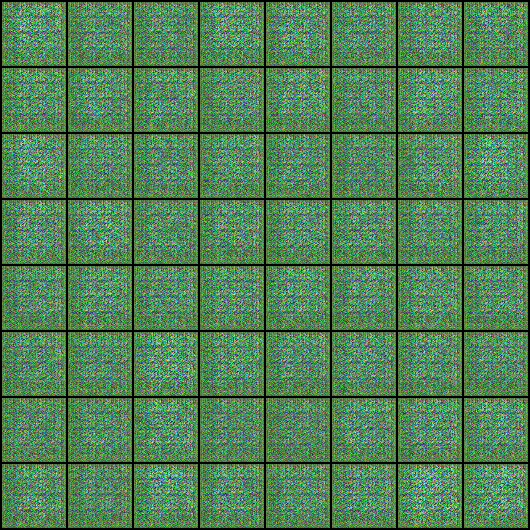

Epoch [25/250]
	Loss D Real:	0.0526481494307518
	Loss D Fake:	0.05714630335569382
	Loss D Total:	0.10979445278644562
	Loss G:	0.43846142292022705
	Loss Total:	0.5482558757066727


KeyboardInterrupt: 

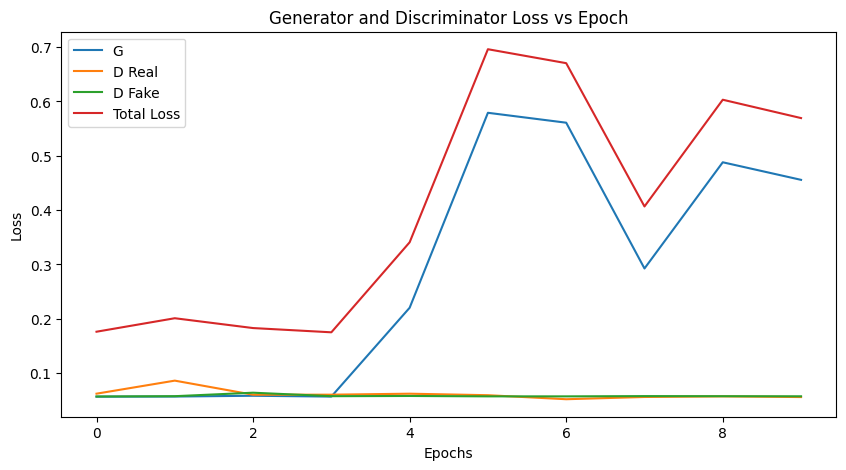

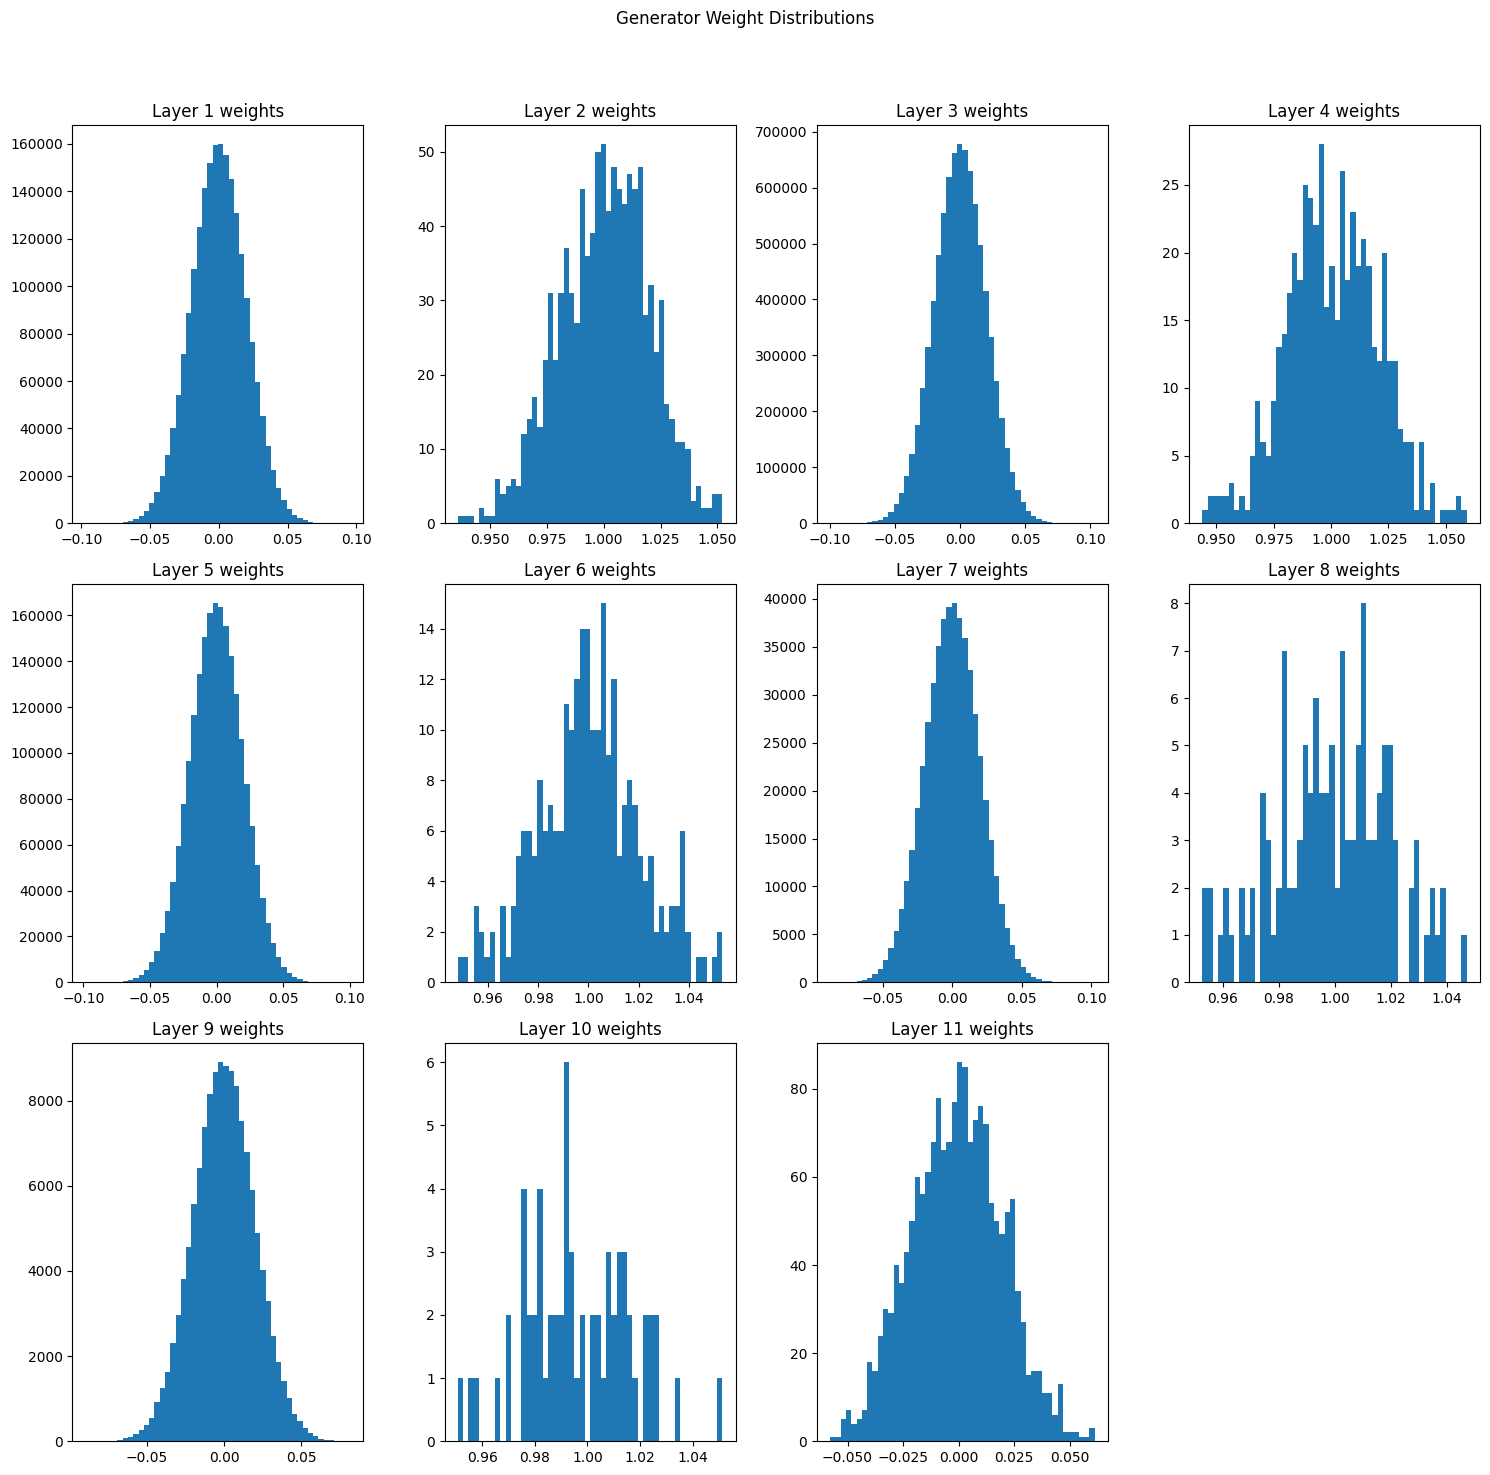

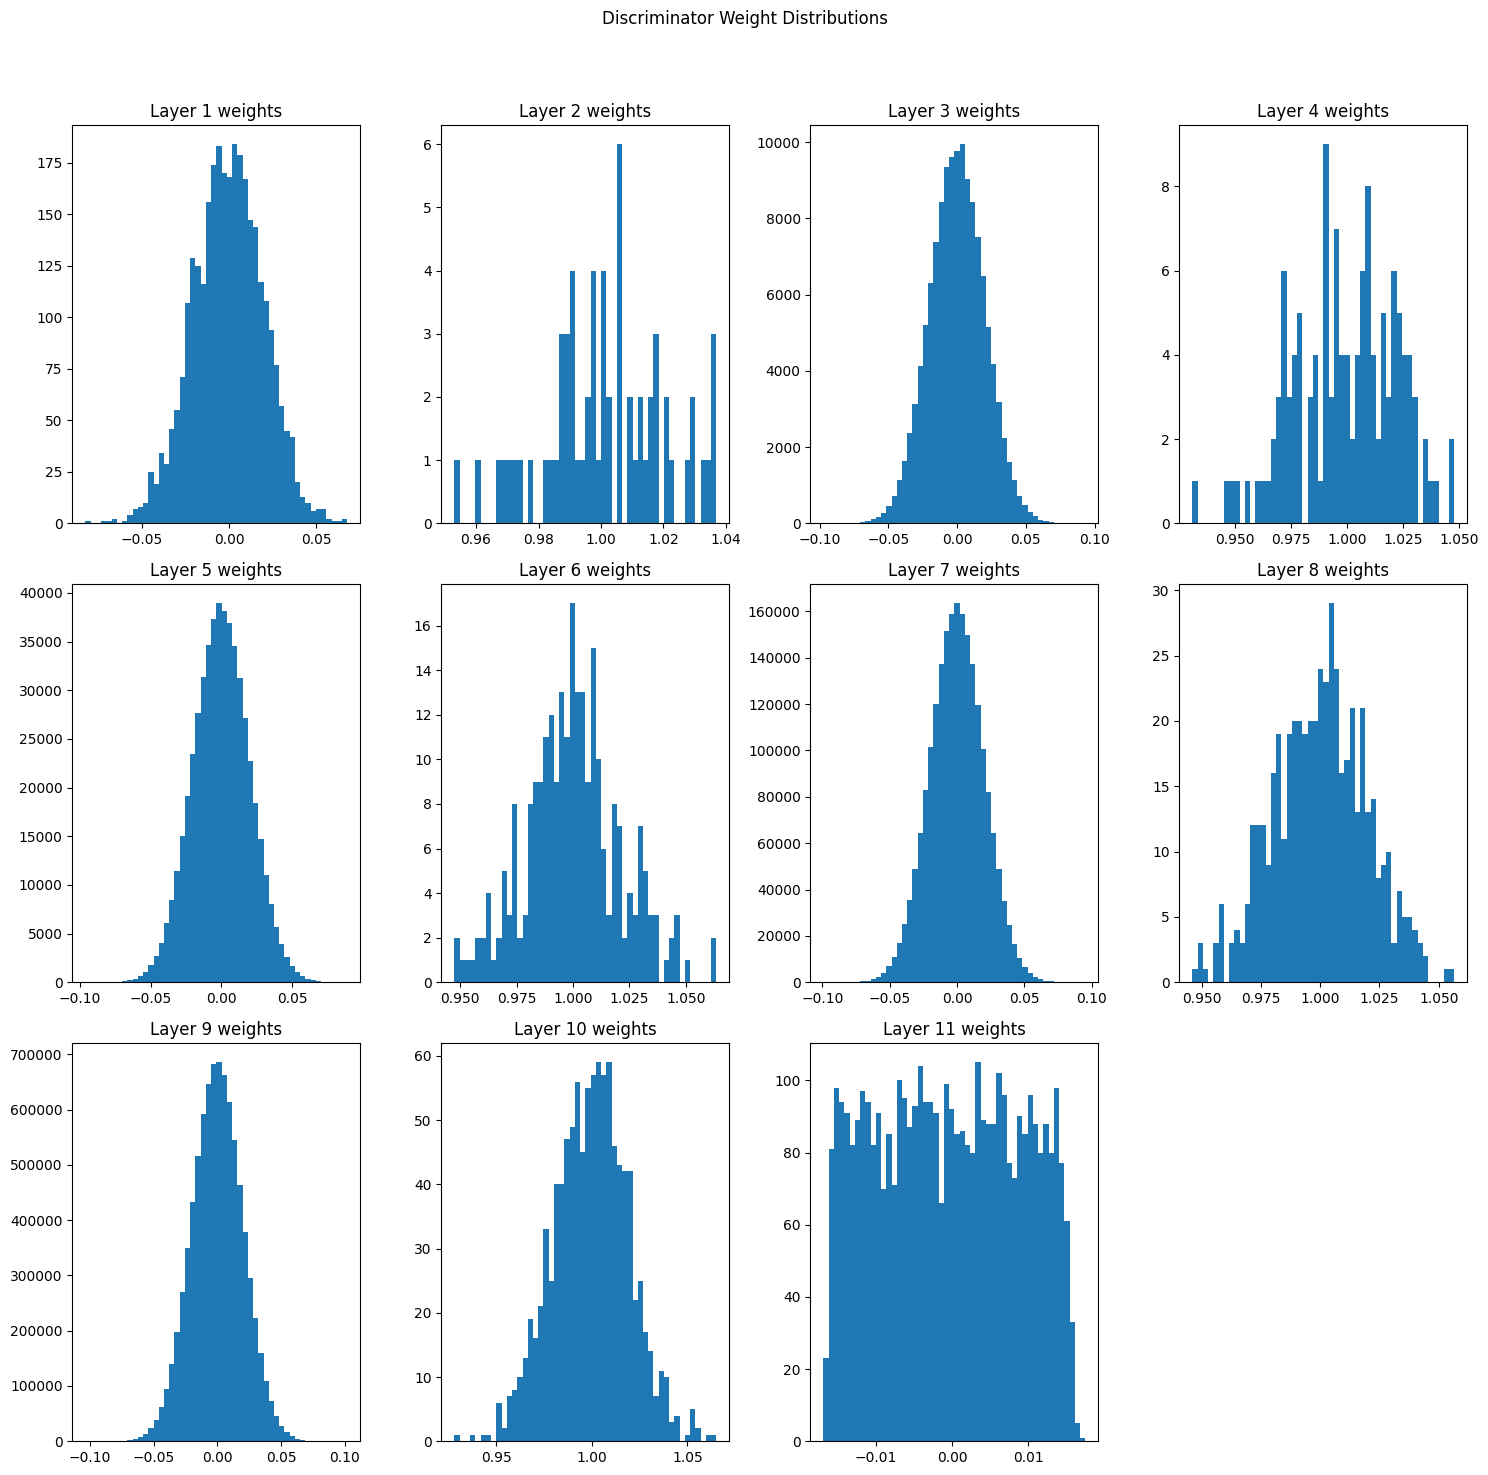

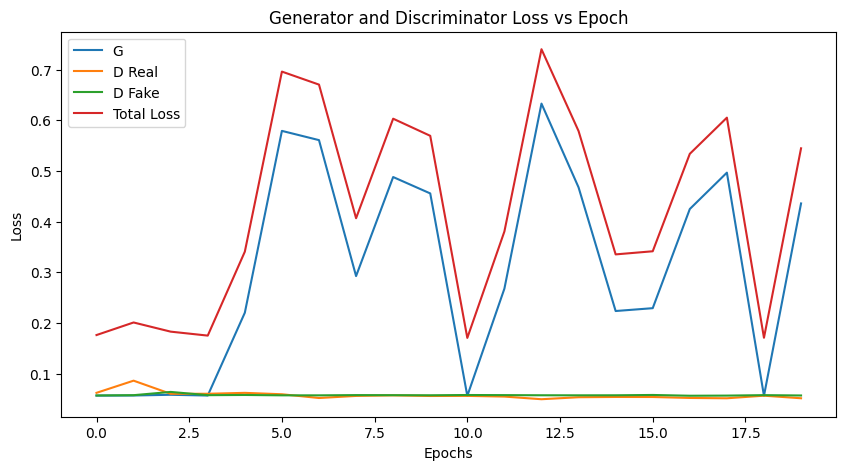

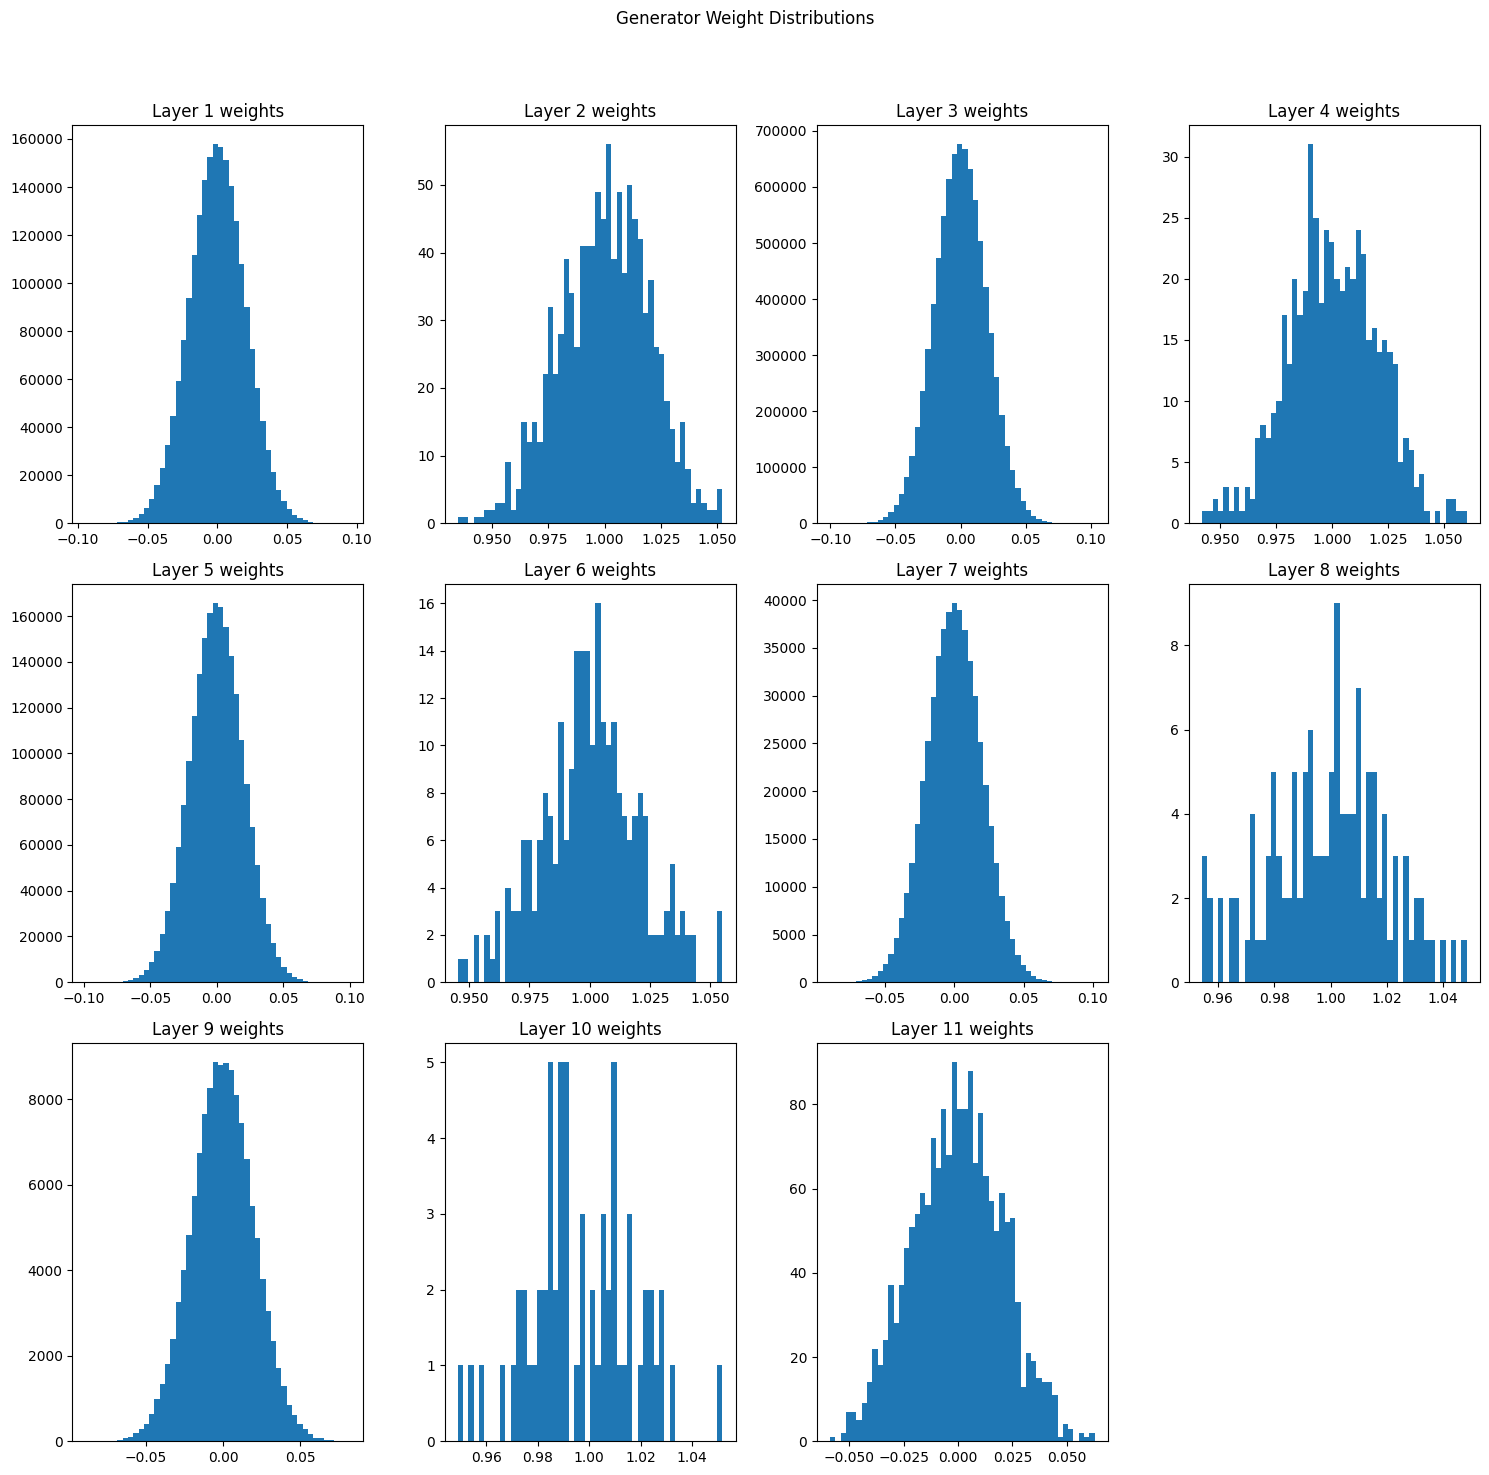

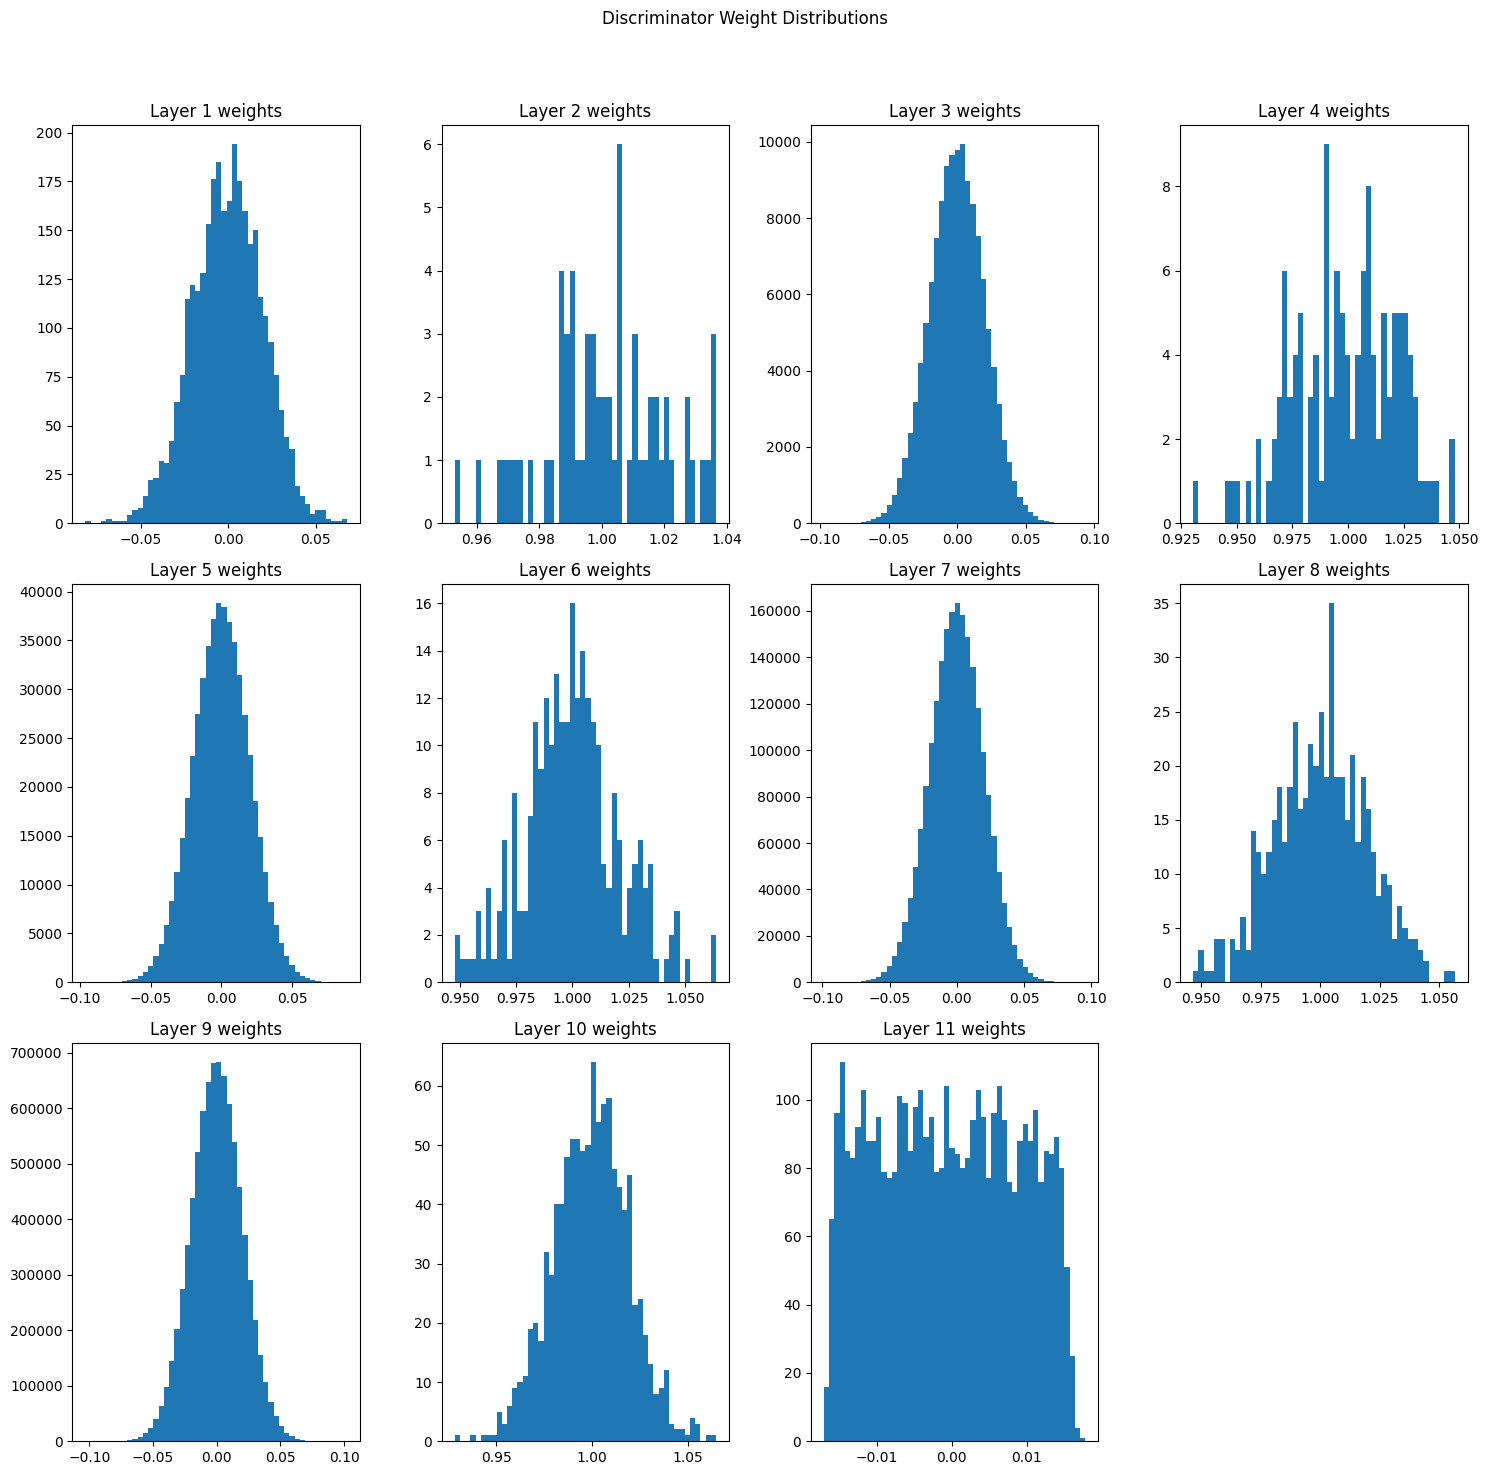

In [9]:
from IPython.display import clear_output, display

lossG_list = []
lossD_real_list = []
lossD_fake_list = []
total_loss_list = []

num_epochs = 250

for epoch in range(num_epochs):
    lossD_real = -1
    lossD_fake = -1
    lossG = -1
    for i, data in enumerate(dataloader, 0):
        real_images, real_labels = data
        real_images = real_images.to(device)

        batch_size = real_images.size(0)
        
        # Label Smoothing for real images.
        real_labels = ((real_labels + 0.01) * 0.99).unsqueeze(1).to(device)
        fake_labels = torch.full((batch_size,), 0.01, dtype=torch.float, device=device).unsqueeze(1)
        
        # Train Discriminator with real images
        netD.zero_grad()
        output_real = netD(real_images)
        lossD_real = criterion(output_real, real_labels)
        
        # Train Discriminator with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, fake_labels)
        
        # Weight the loss on real more.
        lossD = lossD_real + lossD_fake
        lossD.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(netD.parameters(), clip_value)
        
        optimizerD.step()
        
        # Train Generator
        netG.zero_grad()
        output_fake = netD(fake_images)
        lossG = criterion(output_fake, real_labels)
        lossG.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(netG.parameters(), clip_value)
        
        optimizerG.step()
    
    # Save generated images for impactful display.
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
    
    # Store losses so we can make nice plots.
    lossG_list.append(lossG.item())
    lossD_real_list.append(lossD_real.item())
    lossD_fake_list.append(lossD_fake.item())
    total_loss_list.append(lossD_real.item() + lossD_fake.item() + lossG.item())
    
    
    clear_output()
    img_epoch = (epoch+1) if (epoch+1) % 5 == 0 else "latest"
    save_image(fake_images, f'artifact/generated/epoch_{img_epoch}.png', normalize=True)
    display(Image.open(f'artifact/generated/epoch_{img_epoch}.png'))
    print(f'Epoch [{epoch}/{num_epochs}]\n\t'
              f'Loss D Real:\t{lossD_real.item()}\n\t'
              f'Loss D Fake:\t{lossD_fake.item()}\n\t'
              f'Loss D Total:\t{lossD_real.item() + lossD_fake.item()}\n\t'
              f'Loss G:\t{lossG.item()}\n\t'
              f'Loss Total:\t{lossD_real.item() + lossD_fake.item() + lossG.item()}')
    if (epoch+1) % 10 == 0 or epoch == num_epochs - 1:
        plot_loss_vs_epoch(lossG_list, lossD_real_list, lossD_fake_list, total_loss_list)
        plot_weight_distributions(netG, 'Generator Weight Distributions')
        plot_weight_distributions(netD, 'Discriminator Weight Distributions')